In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Reshape, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2025-05-25 23:32:28.767486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_mfcc(mfcc, fs):
    plt.figure(figsize=(12,6))    
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')
    plt.title('MFCCs')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()


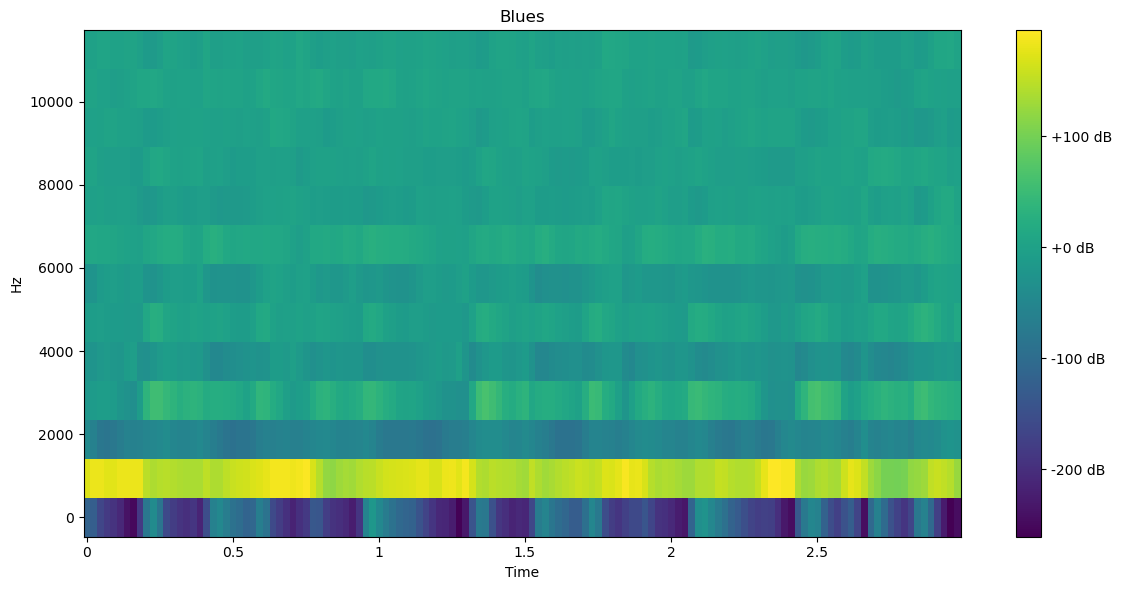

In [30]:
path_prefix = "/home/efectn/python-music-classification"
feature_path = os.path.join(path_prefix, "dataset/features_3.0_sec.json")
with open(feature_path, "r") as fp:
    data = json.load(fp)
    
idx = 100
fs = 22500
plot_mfcc(np.array(data["mfcc"])[idx].T, fs)
plt.title(f"{np.array(data['genre_name'])[idx].title()}");


In [31]:
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

def plot_history(hist):
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()

def make_prediction(model, X):
    global genres
    preds_num = []
    preds_name = []

    for X_current in X:
        X_current = X_current[np.newaxis, ...]
        pred = model.predict(X_current)
        pred = np.argmax(pred, axis=1)
        preds_num.append(pred[0])
        preds_name.append(genres[pred[0]])
        
    return preds_num, preds_name


X training data shape: (5593, 132, 13), y training data shape: (5593,)
X validation data shape: (1399, 132, 13), y validation data shape: (1399,)


In [32]:
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = X_train_cnn.shape[1:4]
print("a", X_train_cnn.shape)
print("a", X_test_cnn.shape)
print("a", input_shape)

model_cnn1 = Sequential()

model_cnn1.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn1.add(Conv2D(64, 3, activation='relu'))
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same'))

model_cnn1.add(Conv2D(64, 2, activation='relu'))
model_cnn1.add(MaxPooling2D(2, strides=(2,2), padding='same'))

model_cnn1.add(Flatten())
model_cnn1.add(Dense(64, activation='relu'))

model_cnn1.add(Dense(10, activation='softmax')) 

model_cnn1.summary()


a (5593, 132, 13, 1)
a (2997, 132, 13, 1)
a (132, 13, 1)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 130, 11, 32)       320       
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 65, 6, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 63, 4, 64)         18496     
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 32, 2, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 31, 1, 64)         16448     
                                                              

In [ ]:
model_cnn1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

hist_cnn1 = model_cnn1.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

In [ ]:
loss_cnn1, acc_cnn1 = model_cnn1.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn1}")
print(f"Test Accuracy: {acc_cnn1}")

plot_history(hist_cnn1)

In [64]:
model_cnn2 = Sequential()

model_cnn2.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.2))

model_cnn2.add(Conv2D(64, 3, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

model_cnn2.add(Conv2D(64, 2, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

model_cnn2.add(Flatten())
model_cnn2.add(Dense(128, activation='relu'))
model_cnn2.add(Dropout(0.5))

model_cnn2.add(Dense(10, activation='softmax'))

model_cnn2.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 130, 11, 32)       320       
                                                                 
 batch_normalization_16 (Bat  (None, 130, 11, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 65, 6, 32)        0         
 g2D)                                                            
                                                                 
 dropout_82 (Dropout)        (None, 65, 6, 32)         0         
                                                                 
 conv2d_89 (Conv2D)          (None, 63, 4, 64)         18496     
                                                                 
 batch_normalization_17 (Bat  (None, 63, 4, 64)      

In [65]:
model_cnn2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

hist_cnn2 = model_cnn2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
88/88 [==============================] - 4s 40ms/step - loss: 3.0628 - acc: 0.1897 - val_loss: 2.1583 - val_acc: 0.2423
Epoch 2/250
88/88 [==============================] - 3s 36ms/step - loss: 2.3388 - acc: 0.2884 - val_loss: 1.8029 - val_acc: 0.3317
Epoch 3/250
88/88 [==============================] - 3s 35ms/step - loss: 2.0343 - acc: 0.3338 - val_loss: 1.6416 - val_acc: 0.3974
Epoch 4/250
88/88 [==============================] - 3s 35ms/step - loss: 1.8725 - acc: 0.3676 - val_loss: 1.5682 - val_acc: 0.4382
Epoch 5/250
88/88 [==============================] - 3s 36ms/step - loss: 1.7739 - acc: 0.3935 - val_loss: 1.5084 - val_acc: 0.4496
Epoch 6/250
88/88 [==============================] - 3s 36ms/step - loss: 1.6887 - acc: 0.4112 - val_loss: 1.4727 - val_acc: 0.4639
Epoch 7/250
88/88 [==============================] - 3s 35ms/step - loss: 1.6081 - acc: 0.4330 - val_loss: 1.5145 - val_acc: 0.4832
Epoch 8/250
88/88 [==============================] - 3s 36ms/step - loss: 1.

141/141 [==============================] - 1s 7ms/step - loss: 0.6217 - acc: 0.8256
Test Loss: 0.6216985583305359
Test Accuracy: 0.8256227970123291


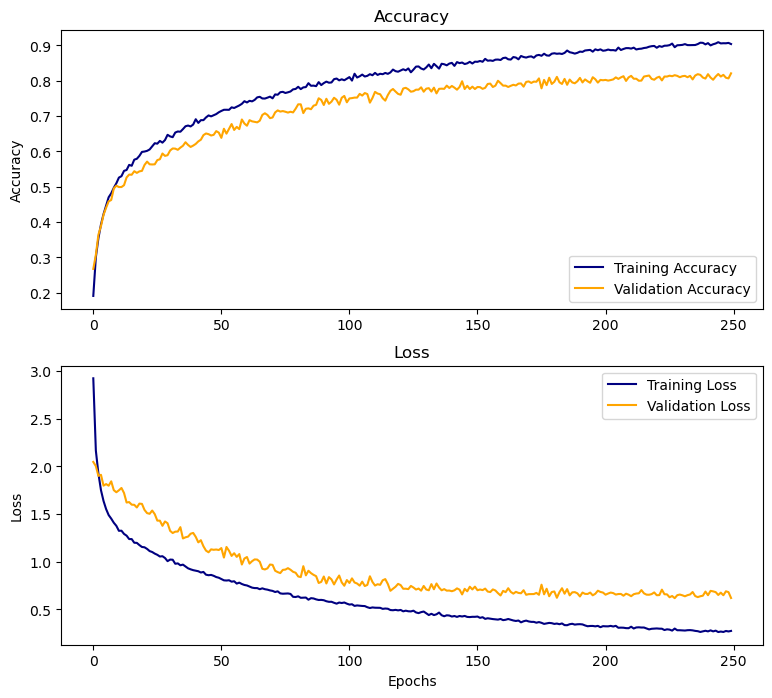

In [9]:
loss_cnn2, acc_cnn2 = model_cnn2.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn2}")
print(f"Test Accuracy: {acc_cnn2}")

plot_history(hist_cnn2)

In [42]:
from tensorflow.python.keras.layers import RepeatVector
from tensorflow.python.keras.regularizers import l1

model_cnn3 = Sequential()
# Conv Block 1
model_cnn3.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn3.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn3.add(BatchNormalization())

# 2nd conv layer
model_cnn3.add(Conv2D(64, (3, 3), activation='relu',
                                   kernel_initializer='he_uniform',
                                   kernel_regularizer=l2(0.0001)))
model_cnn3.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(Dropout(0.3))

# 3rd conv layer
model_cnn3.add(Conv2D(128, (2, 2), activation='relu',
                                   kernel_initializer='he_uniform',
                                   kernel_regularizer=l2(0.0001)))
model_cnn3.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(Dropout(0.3))

# Flatten and Dense layer
model_cnn3.add(Flatten())
model_cnn3.add(Dense(128, activation='relu',
                                  kernel_initializer='he_uniform',
                                  kernel_regularizer=l2(0.0001)))
model_cnn3.add(BatchNormalization())
model_cnn3.add(Dropout(0.3))

# Output layer
model_cnn3.add(Dense(10, activation='softmax'))

model_cnn3.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 130, 11, 32)       320       
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 65, 6, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 65, 6, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_86 (Conv2D)          (None, 63, 4, 64)         18496     
                                                                 
 max_pooling2d_86 (MaxPoolin  (None, 32, 2, 64)        0         
 g2D)                                                            
                                                     

In [43]:
datagen = ImageDataGenerator(vertical_flip=True)

callbacks = [
             EarlyStopping(patience=10)
]

model_cnn3.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

hist_cnn3 = model_cnn3.fit(
    datagen.flow(X_train_cnn, y_train),
    validation_data=(X_val_cnn, y_val),
    batch_size=32,
    epochs=100,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100
175/175 [==============================] - 4s 16ms/step - loss: 2.4601 - acc: 0.2761 - val_loss: 1.7057 - val_acc: 0.4224
Epoch 2/100
175/175 [==============================] - 3s 15ms/step - loss: 1.9367 - acc: 0.3953 - val_loss: 1.4257 - val_acc: 0.5218
Epoch 3/100
175/175 [==============================] - 3s 16ms/step - loss: 1.7158 - acc: 0.4448 - val_loss: 1.3141 - val_acc: 0.5590
Epoch 4/100
175/175 [==============================] - 3s 16ms/step - loss: 1.5704 - acc: 0.4861 - val_loss: 1.2266 - val_acc: 0.6119
Epoch 5/100
175/175 [==============================] - 3s 15ms/step - loss: 1.5121 - acc: 0.5047 - val_loss: 1.1795 - val_acc: 0.6097
Epoch 6/100
175/175 [==============================] - 3s 15ms/step - loss: 1.4221 - acc: 0.5384 - val_loss: 1.1457 - val_acc: 0.6297
Epoch 7/100
175/175 [==============================] - 3s 15ms/step - loss: 1.3782 - acc: 0.5421 - val_loss: 1.0916 - val_acc: 0.6476
Epoch 8/100
175/175 [==============================] - 3s 16ms

94/94 [==============================] - 0s 4ms/step - loss: 0.6411 - acc: 0.8075
Test Loss: 0.6411479711532593
Test Accuracy: 0.8074741363525391


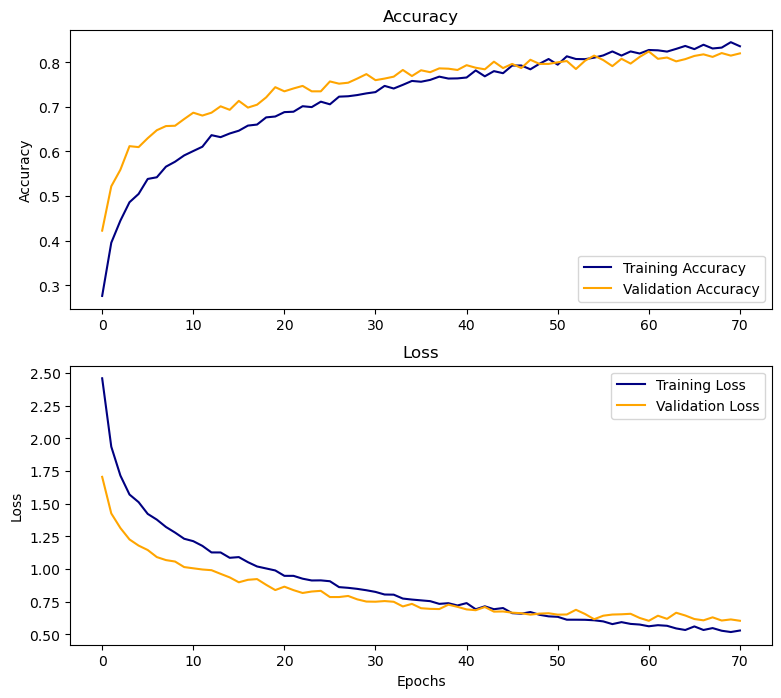

In [44]:
loss_cnn3, acc_cnn3 = model_cnn3.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn3}")
print(f"Test Accuracy: {acc_cnn3}")

plot_history(hist_cnn3)

In [11]:
preds_num, preds_name = make_prediction(model_cnn2, X_test)

1/1 [==============================] - 0s 14ms/step


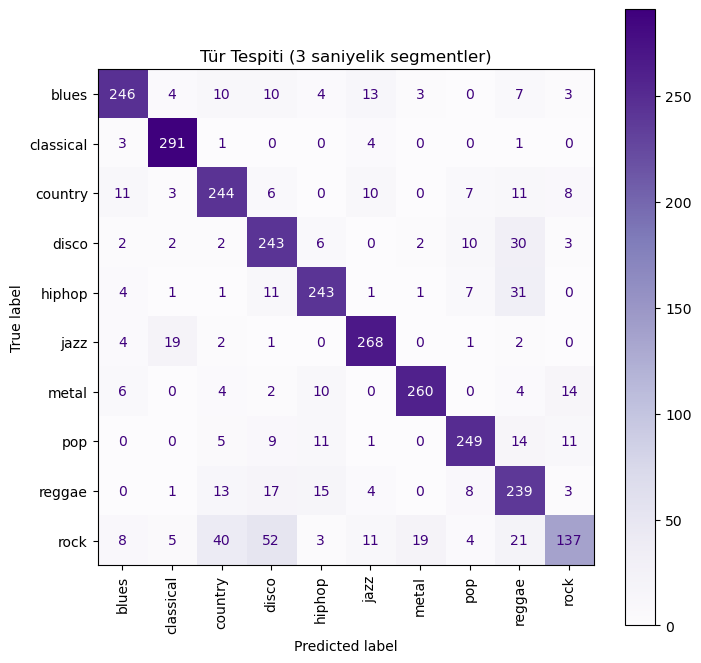

In [114]:
cm = confusion_matrix(y_test, preds_num)

fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap = 'Purples', xticks_rotation='vertical')
plt.title('Tür Tespiti (3 saniyelik segmentler)');


In [45]:
preds_num, preds_name = make_prediction(model_cnn3, X_test)

1/1 [==============================] - 0s 15ms/step


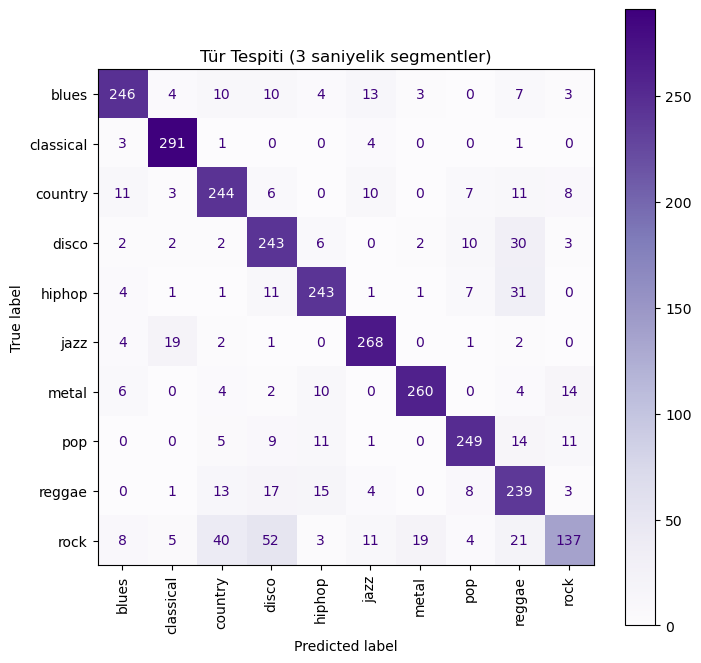

In [113]:
cm = confusion_matrix(y_test, preds_num)

fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap = 'Purples', xticks_rotation='vertical')
plt.title('Tür Tespiti (3 saniyelik segmentler)');

In [10]:
model_cnn2.save(os.path.join(path_prefix, "models/model_cnn.h5"))

In [47]:
model_cnn3.save(os.path.join(path_prefix, "models/model_cnn2.h5"))

In [117]:
import math
import numpy as np
import librosa

def load_and_pad_audio(audio_file, sample_rate=22500, target_duration=30):
    signal, sr = librosa.load(audio_file, sr=sample_rate)
    total_duration = librosa.get_duration(y=signal, sr=sr)

    target_length = sample_rate * target_duration  # örn. 30 saniye
    full_segments = int(np.ceil(total_duration / target_duration))

    padded_signal = []

    for i in range(full_segments):
        start = int(i * target_length)
        end = int((i + 1) * target_length)
        segment = signal[start:end]

        if len(segment) < target_length:
            # Padding with zeros to reach 30s
            padding = np.zeros(int(target_length - len(segment)))
            segment = np.concatenate((segment, padding))

        padded_signal.append(segment)

    return padded_signal, sr

def extract_mfcc_segments(segment, sr, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    samples_per_segment = int(len(segment) / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    mfccs = []
    for d in range(num_segments):
        start = samples_per_segment * d
        finish = start + samples_per_segment

        mfcc = librosa.feature.mfcc(
            y=segment[start:finish],
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mfcc=num_mfcc
        )
        mfcc = mfcc.T
        if mfcc.shape[0] == num_mfcc_vectors_per_segment:
            mfccs.append(mfcc)

    return np.array(mfccs)

audio_path = path_prefix + "/sample9.wav"
segments, sr = load_and_pad_audio(audio_path, sample_rate=22500, target_duration=30)

all_mfcc_segments = []

for segment in segments:
    mfcc_segments = extract_mfcc_segments(segment, sr)
    all_mfcc_segments.extend(mfcc_segments)

segment_predictions = []
for mfcc_segment in all_mfcc_segments:
    X = mfcc_segment[np.newaxis, ..., np.newaxis]
    prediction = model_cnn3.predict(X)
    segment_predictions.append(prediction[0])

average_prediction = np.mean(segment_predictions, axis=0)

genre_dict = {
    0: "blues", 1: "classical", 2: "country", 3: "disco", 4: "hiphop",
    5: "jazz", 6: "metal", 7: "pop", 8: "reggae", 9: "rock"
}

for i, percent in enumerate(average_prediction * 100):
    print(f"{genre_dict[i]:<10}: {percent:.2f}%")

predicted_index = np.argmax(average_prediction)
print("\n🎵 Predicted Genre:", genre_dict[int(predicted_index)])


1/1 [==============================] - 0s 18ms/step
blues     : 0.05%
classical : 86.90%
country   : 1.22%
disco     : 0.05%
hiphop    : 1.23%
jazz      : 2.51%
metal     : 0.10%
pop       : 1.59%
reggae    : 5.66%
rock      : 0.69%

🎵 Predicted Genre: classical
